# Monolithic Neural Network

1D two-layer neural network with sigmoid activation unit and cross-entropy loss. Includes support for:

- Minibatching
- Optional gradient checking
- L2 Regularization
- Logging so you can see what the scores, probabilities, gradients, etc. were after every minibatch

In [1]:
from collections import namedtuple

Model = namedtuple('Model', ['x', 'y', 'wh', 'bh', 'z', 'w1', 'b1', 'score1', 'w2', 'b2', 'score2', 'prob1', 'prob2', 'dscore1', 'dscore2', 'db1', 'dw1', 'db2', 'dw2', 'loss'])
State = namedtuple('State', ['loss', 'dwh', 'dbh', 'dws', 'dbs'])

In [2]:
from lib.softmax import softmax
from lib.neural_net import sigmoid, sigmoid_grad

class NeuralNetwork:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    If you want to inspect the scores after each training example, the pass inspect. If you do
    this then you better set a batch_size to 1. Otherwise you'll only ever get the scores of
    the last training example in the minibatch
    
    """
    def __init__(self, xs_train, ys_train, wh=None, bh=None, ws=None, bs=None,
                 learning_rate=0.001, regularizer=1., batch_size=None,
                gradient_checking=False, inspect=False):
        """Initializes monolithic neural network model
        
        Parameters
        ----------
        xs_train : list of inputs
        ys_train : list of labels
        wh : weight of hidden layer
        bh : bias term of hidden layer
        ws : list (length 2) of softmax class weights
        bs : list (length 2) of softmax class biases
        learning_rate : learning rate constant
        regularizer : regularization constant
        batch_size : size of minibatch
        gradient_checking : boolean whether to perform gradient checking during training
        inspect : boolean whether to log all data after every learning session from a training example
        
        """
        self.m = len(xs_train)
        
        self.xs_train, self.ys_train = xs_train, ys_train
        
        # Randomly initialize weights and biases
        self.wh, self.bh = np.random.randn(), np.random.randn()
        self.ws = np.array([np.random.randn(), np.random.randn()])
        self.bs = np.array([np.random.randn(), np.random.randn()])
        
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        
        self.batch_size = self.m if not batch_size else batch_size
        self.batch_index = 0
        
        self.gradient_checking = gradient_checking
        self.inspect = inspect
        
        # Info from the *last* training example that was used to learn from
        self.x, self.y = None, None
        self.z, self.hidden = None, None
        self.scores, self.dscores = None, None
        self.probs = None
        self.dws, self.dbs = None, None
        self.dhidden, self.dz = None, None
        self.dwh, self.dbh = None, None
        self.loss = None
        
    def predict(self, x):
        """Return the probability of x belonging to either class"""
        
        hidden = sigmoid(self.wh*x + self.bh)
        scores = np.array([hidden,hidden])*self.ws + self.bs
        
        return hidden, scores, softmax(scores)
        
    def forward_backward_prop(self, wh=None, bh=None, ws=None, bs=None, predict=False):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        wh = self.wh if not wh else wh
        bh = self.bh if not bh else bh
        ws = self.ws if not type(ws) == np.ndarray else ws
        bs = self.bs if not type(bs) == np.ndarray else bs
        
        loss, dwh, dbh, dws, dbs = 0., 0., 0., np.array([0.,0.]), np.array([0.,0.])
        lower, upper = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        for x, y in zip(self.xs_train[lower:upper], self.ys_train[lower:upper]):
            # Forward propagation
            z = wh*x + bh
            hidden = sigmoid(z)
            scores = np.array([hidden,hidden])*ws + bs
            probs = softmax(scores)

            # Accumulate performance loss and regularization loss
            loss += -np.log(probs[y])
            loss += self.regularizer * 0.5*(wh**2 + bh**2 + (ws**2).sum() + (bs**2).sum())

            # Backpropagate to accumulate dbs, dws, dbh, and dwh
            dloss = 1
            dscores = probs
            dscores[y] -= 1
            
            dbs += dscores
            dws += hidden * dscores 
            
            dhidden = sum(ws*dscores)
            dz = sigmoid_grad(hidden) * dhidden
            
            dbh += dz
            dwh += x * dz
            
            # Add regularization
            dwh += self.regularizer*wh
            dbh += self.regularizer*bh
            dws += self.regularizer*ws
            dbs += self.regularizer*bs
            
            # Log additional info?
            if self.inspect:
                self.x, self.y = x, y
                self.z = z
                self.hidden = hidden
                self.scores, self.dscores = scores, dscores
                self.dscores[y] += 1
                self.probs = probs
                self.dhidden = dhidden
                self.dz = dz
                self.dbh = dbh
                self.dwh = dwh
        
        return State(loss/self.m, dwh/self.m, dbh/self.m, dws/self.m, dbs/self.m)
    
    def learn(self):
        """Learn from a minibatch of training examples
        
        Have the model run forward-backward prop on these examples and average the gradients
        
        """
        loss, dwh, dbh, dws, dbs = self.forward_backward_prop()
        
        self.gradient_check(dwh, dbh, dws, dbs)
        
        self.wh = self.wh - self.learning_rate*dwh
        self.bh = self.bh - self.learning_rate*dbh
        self.ws = self.ws - self.learning_rate*dws
        self.bs = self.bs - self.learning_rate*dbs
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.m//self.batch_size)
        
        # Log additional info?
        if self.inspect:
            self.dwh = dwh
            self.dbh = dbh
            self.dws = dws
            self.dbs = dbs
            self.loss = loss
    
    def gradient_check(self, analytic_dwh, analytic_dbh, analytic_dws, analytic_dbs):
        """Verify gradient correctness
        
        The analytic dwh, dbh, dws, and dbs come from doing forward-backward
        prop just a second ago. We numerically estimate these gradients on
        the *same* minibatch the analytic gradients were computed from and
        compare them to see if they are close.
        
        Note the same minibatch is being used because this function gets
        called *before* the update to batch_index
        
        """
        if not self.gradient_checking:
            return
        
        numerical_dwh, numerical_dbh, numerical_dws, numerical_dbs = self.numerical_gradients()

        # Compute relative error
        dwh_error = abs(numerical_dwh - analytic_dwh) / (abs(numerical_dwh) + abs(analytic_dwh))
        dbh_error = abs(numerical_dbh - analytic_dbh) / (abs(numerical_dbh) + abs(analytic_dbh))
        dws_error = abs(numerical_dws - analytic_dws) / (abs(numerical_dws) + abs(analytic_dws))
        dbs_error = abs(numerical_dbs - analytic_dbs) / (abs(numerical_dbs) + abs(analytic_dbs))

        try:
            assert(np.linalg.norm(dws_error) < 1e-6 and
                   np.linalg.norm(dbs_error) < 1e-6 and dwh_error < 1e-6 and dbh_error < 1e-6)
        except AssertionError:
            warn('Gradient check failed!')
            warn('dwh relative error: {}'.format(dwh_error))
            warn('dbh relative error: {}'.format(dbh_error))
            warn('dws relative error: {}'.format(dws_error))
            warn('dbs relative error: {}'.format(dbs_error))
            
    def numerical_gradients(self):
        """Compute numerical gradients of f with respect to self.wh, self.bh, self.ws, and self.bs

        Returns approximation for df/dwh, df/dbh, df/dws, and df/dbs

        """
        dwh, dbh, dws, dbs = 0., 0., np.zeros_like(self.ws), np.zeros_like(self.bs)
        h = np.zeros_like(self.ws)
        step = 0.00001
        wh, bh, ws, bs = self.wh, self.bh, self.ws, self.bs

        # df/dw1 and df/db1
        h[0] = step
        dws[0] = (self.forward_backward_prop(wh, bh, ws+h, bs).loss  -self.forward_backward_prop(wh, bh, ws-h, bs).loss)   / (2*step)
        dbs[0] = (self.forward_backward_prop(wh, bh, ws,   bs+h).loss-self.forward_backward_prop(wh, bh, ws,   bs-h).loss) / (2*step)
        h[0] = 0

        # df/dw1 and df/db1
        h[1] = step
        dws[1] = (self.forward_backward_prop(wh, bh, ws+h, bs).loss  -self.forward_backward_prop(wh, bh, ws-h, bs).loss)   / (2*step)
        dbs[1] = (self.forward_backward_prop(wh, bh, ws,   bs+h).loss-self.forward_backward_prop(wh, bh, ws,   bs-h).loss) / (2*step)
        h[1] = 0
        
        # df/dwh and df/dbh
        dwh = (self.forward_backward_prop(wh+step, bh, ws, bs).loss - self.forward_backward_prop(wh-step, bh, ws, bs).loss) / (2*step)
        dbh = (self.forward_backward_prop(wh, bh+step, ws, bs).loss - self.forward_backward_prop(wh, bh-step, ws, bs).loss) / (2*step)

        return dwh, dbh, dws, dbs

    @property
    def info(self):
        return Model(self.x, self.y,
                     self.wh, self.bh, self.z,
                     self.ws[0], self.bs[0], self.scores[0], self.ws[1], self.bs[1], self.scores[1],
                     self.probs[0], self.probs[1],
                     self.dscores[0], self.dscores[1],
                     self.dbs[0], self.dws[0],
                     self.dbs[1], self.dws[1],
                     self.loss)

## Start Learning!

In [3]:
from data.softmax import xs_train, ys_train

sm = NeuralNetwork(xs_train, ys_train, learning_rate=0.1, regularizer=.01, batch_size=1, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        sm.learn()
        yield sm.info
        
states = list(states(5000))

x   y
-1  0    Axes(0.125,0.125;0.775x0.775)
 1  1    Axes(0.125,0.125;0.775x0.775)
Name: loss, dtype: object

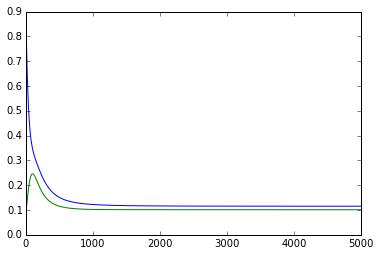

In [4]:
df = pd.DataFrame(states, columns=Model._fields)

df.groupby(['x', 'y'])['loss'].plot()

## Plot the Weights!

In [5]:
df = pd.DataFrame(states, columns=Model._fields)

df[['x', 'y', 'wh', 'bh', 'w1', 'w2', 'b1', 'b2', 'score1', 'score2', 'prob1', 'prob2', 'loss']]

,x,y,wh,bh,w1,w2,b1,b2,score1,score2,prob1,prob2,loss
0,1,1,0.816190,-1.404383,-0.930885,0.379282,-1.492054,-0.120267,-1.816551,0.006940,0.139016,0.860984,0.089520
1,-1,0,0.820513,-1.408411,-0.926417,0.375089,-1.450429,-0.161086,-1.583205,-0.083128,0.182414,0.817586,0.865462
2,1,1,0.822307,-1.405503,-0.928588,0.377536,-1.457080,-0.153629,-1.781269,-0.027135,0.147527,0.852473,0.094270
3,-1,0,0.826524,-1.409428,-0.924199,0.373422,-1.416003,-0.193901,-1.547414,-0.116902,0.193019,0.806981,0.836991
4,1,1,0.828440,-1.406394,-0.926534,0.376033,-1.423103,-0.185996,-1.747110,-0.060117,0.156172,0.843828,0.099168
5,-1,0,0.832554,-1.410219,-0.922222,0.371996,-1.382579,-0.225715,-1.512667,-0.149646,0.203750,0.796250,0.809741
6,1,1,0.834595,-1.407057,-0.924725,0.374775,-1.390134,-0.217356,-1.714090,-0.091994,0.164916,0.835084,0.104194
7,-1,0,0.838610,-1.410785,-0.920490,0.370814,-1.350167,-0.256520,-1.478974,-0.181351,0.214565,0.785435,0.783699
8,1,1,0.840777,-1.407493,-0.923163,0.373762,-1.358178,-0.247705,-1.682220,-0.122754,0.173723,0.826277,0.109331
9,-1,0,0.844695,-1.411128,-0.919003,0.369877,-1.318770,-0.286310,-1.446339,-0.212011,0.225425,0.774575,0.758849


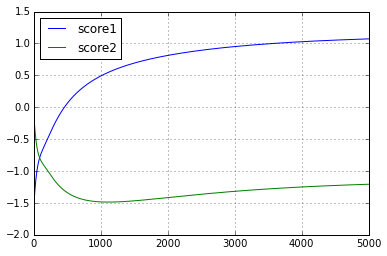

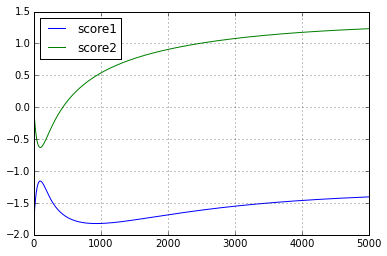

In [6]:
axeses = df.groupby(['x', 'y'])[['score1', 'score2']].plot()
for axes in axeses:
    axes.xaxis.grid(b=True)
    axes.yaxis.grid(b=True)

## How Does the Model Evolve Over Time?

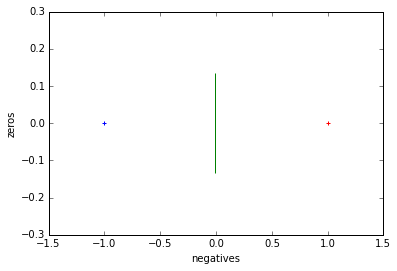

In [7]:
from lib.neural_net import sigmoid_inverse
from ipywidgets import interact, fixed

@interact(xs_train=fixed(xs_train), ys_train=fixed(ys_train), view_index=(0, len(states)), states=fixed(states))
def plot(xs_train, ys_train, view_index, states):
    state = states[view_index]
    
    # Get data into suitable form for plotting
    positives, negatives = xs_train[:len(xs_train)//2], xs_train[len(xs_train)//2:]
    df1 = pd.DataFrame({'positives': positives, 'negatives': negatives, 'zeros': np.zeros_like(positives)})
    
    # Solve for the decision boundary
    decision = (sigmoid_inverse((state.b2-state.b1)/(state.w1-state.w2)) - state.bh) / state.wh
    
    ys = np.linspace(-.001,.001)
    df2 = pd.DataFrame({'x': [decision], 'y': [0]})
    
    axes = df2.plot(kind='scatter', x='x', y='y', color='g', marker='|', s=10000)
    axes = df1.plot(ax=axes, kind='scatter', x='positives', y='zeros', color='r', marker='+')
    df1.plot(ax=axes, kind='scatter', x='negatives', y='zeros', color='b', marker='+')